# Upwinding

The FTCS discretization was unstable, so let's try a different discretization.  We can approximate the space derivative using a one-sided difference as either:

$$ (a_x)_i \approx \frac{a_i - a_{i-1}}{\Delta x} + \mathcal{O}(\Delta x)$$

$$ (a_x)_i \approx \frac{a_{i+1} - a_i}{\Delta x} + \mathcal{O}(\Delta x)$$

We'll choose the one that is an [*upwinded* difference](https://en.wikipedia.org/wiki/Upwind_scheme) &mdash;this means we want to make use of the points from the direction that information is flowing.  In our case, $u > 0$, so we want to use the points to the left of $i$ in approximating our derivative.

Choosing this difference makes us first-order accurate in space and time.  Our difference equation is:

$$\frac{a_i^{n+1} - a_i^n}{\Delta t} = - u \frac{a_i^n - a_{i-1}^n}{\Delta x}$$

and our update is:

$$a_i^{n+1} = a_i^n - C (a_i^n - a_{i-1}^n)$$

In [8]:
import numpy as np
import matplotlib.pyplot as plt

We'll use the same grid class as before

In [19]:
class FDGrid:
    """a finite-difference grid"""

    def __init__(self, nx, ng=1, xmin=0.0, xmax=1.0):
        """create a grid with nx points, ng ghost points (on each end)
        that runs from [xmin, xmax]"""

        self.xmin = xmin
        self.xmax = xmax
        self.ng = ng
        self.nx = nx

        # python is zero-based.  Make easy integers to know where the
        # real data lives
        self.ilo = ng
        self.ihi = ng+nx-1

        # physical coords
        self.dx = (xmax - xmin)/(nx-1)
        self.x = xmin + (np.arange(nx+2*ng)-ng)*self.dx

        # storage for the solution
        self.a = np.zeros((nx+2*ng), dtype=np.float64)
        self.ainit = np.zeros((nx+2*ng), dtype=np.float64)
        
    def scratch_array(self):
        """ return a scratch array dimensioned for our grid """
        return np.zeros((self.nx+2*self.ng), dtype=np.float64)

    def fill_BCs(self):
        """ fill the a single ghostcell with periodic boundary conditions """
        self.a[self.ilo-1] = self.a[self.ihi-1]
        self.a[self.ihi+1] = self.a[self.ilo+1]
        
    def plot(self):
        fig = plt.figure()
        ax = fig.add_subplot(111)

        ax.plot(self.x[self.ilo:self.ihi+1], self.ainit[self.ilo:self.ihi+1], label="initial conditions")
        ax.plot(self.x[self.ilo:self.ihi+1], self.a[self.ilo:self.ihi+1])
        ax.legend()
        return fig

Our upwinding solver is virtually identical to the FTCS solver we just explored.

In [20]:
def upwind_advection(nx, u, C, num_periods=1.0, init_cond=None):
    """solve the linear advection equation using FTCS.  You are required
    to pass in a function f(g), where g is a FDGrid object that sets up
    the initial conditions"""
    
    g = FDGrid(nx)
    
    # time info
    dt = C*g.dx/u
    t = 0.0
    tmax = num_periods*(g.xmax - g.xmin)/u

    # initialize the data
    init_cond(g)

    g.ainit[:] = g.a[:]
    
    # evolution loop
    anew = g.scratch_array()

    while t < tmax:

        if t + dt > tmax:
            dt = tmax - t
            C = u*dt/g.dx

        # fill the boundary conditions
        g.fill_BCs()

        # loop over zones: note since we are periodic and both endpoints
        # are on the computational domain boundary, we don't have to
        # update both g.ilo and g.ihi -- we could set them equal instead.
        # But this is more general
        for i in range(g.ilo, g.ihi+1):
            anew[i] = g.a[i] - C*(g.a[i] - g.a[i-1])

        # store the updated solution
        g.a[:] = anew[:]
        
        t += dt
        
    return g

Let's run it for a period.

In [21]:
def tophat(g):
    g.a[:] = 0.0
    g.a[np.logical_and(g.x >= 1./3, g.x <= 2./3.)] = 1.0

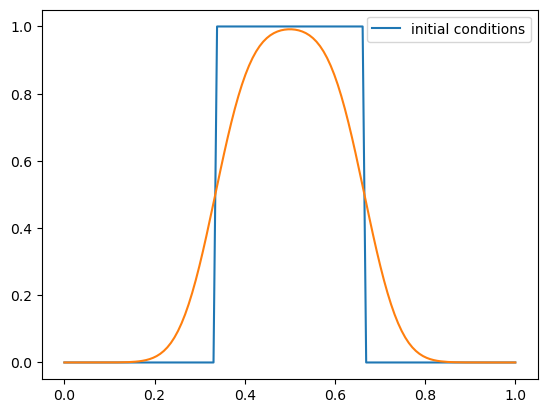

In [22]:
C = 0.5
u = 1.0
nx = 128

g = upwind_advection(nx, u, C, init_cond=tophat)
fig = g.plot()

## Smoother initial conditions

What happens if we start out with smoother initialial conditions, like a sine wave?

In [23]:
def sine(g):
    g.a[:] = np.sin(2 * np.pi * g.x)

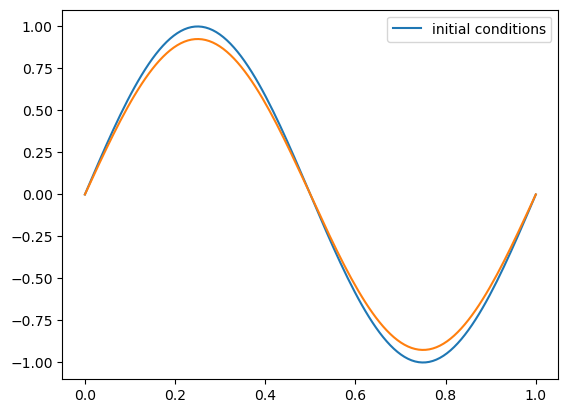

In [24]:
g = upwind_advection(nx, u, C, init_cond=sine)
fig = g.plot()

We see that the solution looks better&mdash;this suggests that a lot of the troubles we have are near discontinuities.

## Stability

If we do the same stability truncation analysis as with FTCS, we have:

$$a_i^{n+1} = a_i^n - C(a_i^n - a_{i-1}^n)$$

inserting

$$a_{i-1}^n = a_i^n - a_x \Delta x + \frac{1}{2} a_{xx} \Delta x^2 + \mathcal{O}(\Delta x^3)$$

and

$$a_i^{n+1} = a_i^n + a_t \Delta t + \frac{1}{2} u^2 a_{xx} \Delta t^2 + \mathcal{O}(\Delta t^3)$$

and grouping terms, we get:

$$a_t + u a_x = \frac{1}{2} u \Delta x (1 - C) a_{xx} + \mathcal{O}(\Delta x^2) + \mathcal{O}(\Delta t^2)$$

Now we see that the leading error term is $\mathcal{O}(\Delta x)$, so
we are first order accurate, and again, it appears as diffusion, but
the diffusion coefficient is positive (physical) so long as:

$$C < 1$$

This is the stability criterion.

## C++ implementation

Here's a C++ implementation that follows the same ideas as the python version developed here:

* [fdgrid.H](../../../examples/advection/upwind/fdgrid.H)
* [initial_conditions.H](../../../examples/advection/upwind/initial_conditions.H)
* [upwind.cpp](../../../examples/advection/upwind/upwind.cpp)

This can be compiled as:

```
g++ -I. -o upwind upwind.cpp
```